In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from window_generator import WindowGenerator

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
# 시간별 예측하기위해 1시간 단위로 잘라냄 [start:stop:step] index 5에서부터 6간격으로 잘라냄
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
# 데이터 살펴보기
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


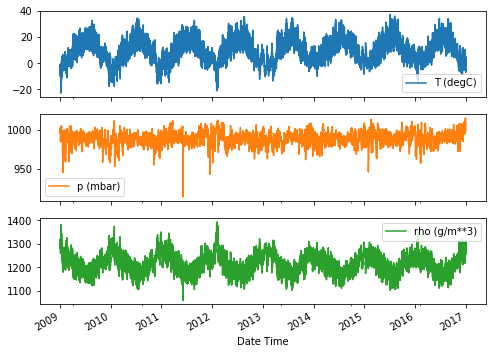

In [5]:
# 온도, 기압, 밀도를 살펴보면 일정한 흐름이 관측됨
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [6]:
# 위의 데이터중 mv 값을 보면 min 값이 -9999 -> 에러를 나타냄
wv = df['wv (m/s)']
max_wv = df['max. wv (m/s)']

bad_wv = wv == -9999.0
bad_max_wv = max_wv == -9999.0

wv[bad_wv] = 0
max_wv[bad_max_wv] = 0

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


# 특성 엔지니어링
모델을 본격적으로 빌드하기 전에 데이터를 이해하고 모델에 적합한 형식의 데이터를 전달하는 것이 중요
### 바람
---
데이터의 마지막 열인 __wd (deg)__ 는 도 단위의 바람방향을 나타낸다. 각도는 모델 입력으로 좋지 않다.
풍향과 속도 열을 바람 **벡터**로 변환하면 모델을 해석하기가 쉬워진다.

Text(0, 0.5, 'Wind Velocity [m/s]')

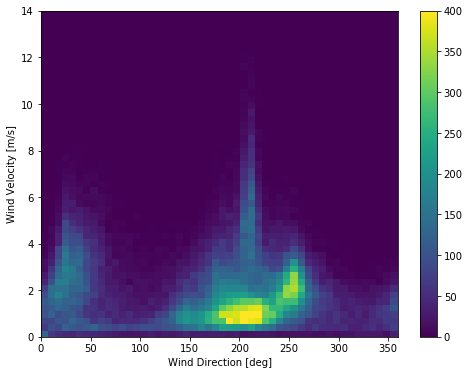

In [7]:
# 풍향과 풍속의 히스토그램
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [8]:
# 바람 벡터로의 변환
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# 도에서 라디안으로 단위 변경
wd_rad = df.pop('wd (deg)')*np.pi / 180

# x방향의 바람과 y방향의 바람으로 분리
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

# max도 동일한 방법으로 변경
df['max Wx'] = max_wv * np.cos(wd_rad)
df['max Wy'] = max_wv * np.sin(wd_rad)

In [9]:
# 결과 확인
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.600000,984.200000,989.570000,994.720000,1015.290000
T (degC),70091.0,9.450482,8.423384,-22.760000,3.350000,9.410000,15.480000,37.280000
Tpot (K),70091.0,283.493086,8.504424,250.850000,277.440000,283.460000,289.530000,311.210000
Tdew (degC),70091.0,4.956471,6.730081,-24.800000,0.240000,5.210000,10.080000,23.060000
rh (%),70091.0,76.009788,16.474920,13.880000,65.210000,79.300000,89.400000,100.000000
VPmax (mbar),70091.0,13.576576,7.739883,0.970000,7.770000,11.820000,17.610000,63.770000
VPact (mbar),70091.0,9.533968,4.183658,0.810000,6.220000,8.860000,12.360000,28.250000
VPdef (mbar),70091.0,4.042536,4.898549,0.000000,0.870000,2.190000,5.300000,46.010000
sh (g/kg),70091.0,6.022560,2.655812,0.510000,3.920000,5.590000,7.800000,18.070000
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.810000,6.290000,8.960000,12.490000,28.740000


(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

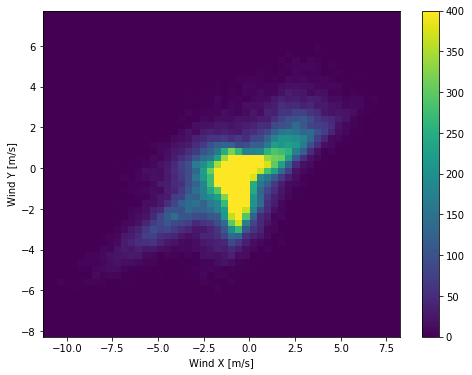

In [10]:
# 히스토그램 그리기
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

# 시간 데이터
`Date Time`열은 매우 유용하지만 데이터 입력으로는 좋지 않다.
## 좋은 데이터로 가공하기
초(sec)도 마찬가지로 좋은 데이터는 아니다. 날씨데이터는 하루 및 연 단위의 주기성이 명확하므로 주기성을 처리해주어야한다.
1. 초(sec)로 변환
2. sin 및 cos 함수를 사용하여 시간을 명확한 `하루 중 시간` 및 `연중 시간` 신호로 변환

$$ day_{peri}=\frac{timestamp*2\pi}{day_{sec}} ,\; year_{peri}=\frac{timestamp*2\pi}{year_{sec}} \\ day_{sin/cos}=sin/cos(day_{val}),\; year_{sin/cos}=sin/cos(year_{val}) $$

In [11]:
timestamp_sec = date_time.map(datetime.datetime.timestamp)

day_sec = 24*60*60
year_sec = 365.2425*day_sec

day_val = timestamp_sec*(2*np.pi)/day_sec
year_val = timestamp_sec*(2*np.pi)/year_sec

df['Day sin'] = np.sin(day_val)
df['Day cos'] = np.cos(day_val)

df['Year sin'] = np.sin(year_val)
df['Year cos'] = np.cos(year_val)

Text(0.5, 1.0, 'Time of day signal')

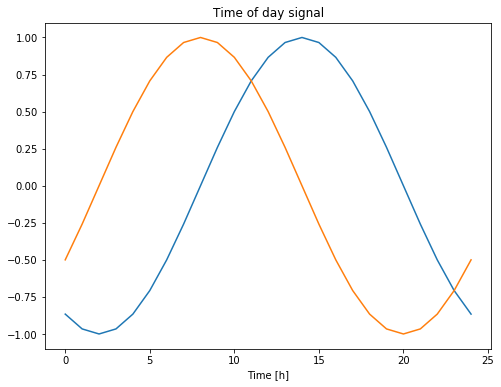

In [12]:
# 결과 확인
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])

plt.xlabel('Time [h]')
plt.title('Time of day signal')

# 중요한 빈도 특성
위의 경우 어떤 빈도가 중요한지 미리 알고 있었지만, 모르는 경우 fft를 사용하여 중요한 빈도를 결정할 수 있다.
시간에 따른 온도의 tf.signal.rfft를 보면 가정한 내용이 확인된다.

# 이해가 안감

2022-03-31 19:19:36.712478: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-31 19:19:36.716535: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


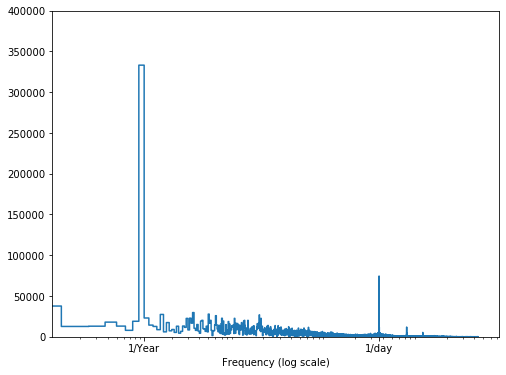

In [13]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/hours_per_year

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# 데이터 분할
훈련 / 검증 / 테스트 세트에 각각 70%, 20%, 10% 사용
분할하기 전에 데이터가 임의로 셔플되지 않아야한다.

## 이유
1. 데이터를 연석된 샘플의 창으로 자르는 것이 여전히 가능
2. 모델을 훈련한 후에 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적이다

In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0: int(n*0.7)]
val_df = df[int(n*0.7): int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# 데이터 정규화
신경망을 훈련하기 전에 특성의 크기를 정하는 것이 중요하다. 정규화는 이 크기 조정을 수행하는 일반적인 방법이다. 평균을 빼고 각 특성의 표준편차로 나눈다.
모델이 검증 및 테스트셋 값에 접근할 수 없도록 훈련데이터를 사용해서만 평균 및 표준 편차를 계산해야함

또한 모델이 훈련할 때, 훈련 세트의 미래 값에 액세스 할 수 없어야하고 이 정규화가 이동평균을 사용하여 수행되어야 한다고 말할 수도 있다.

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

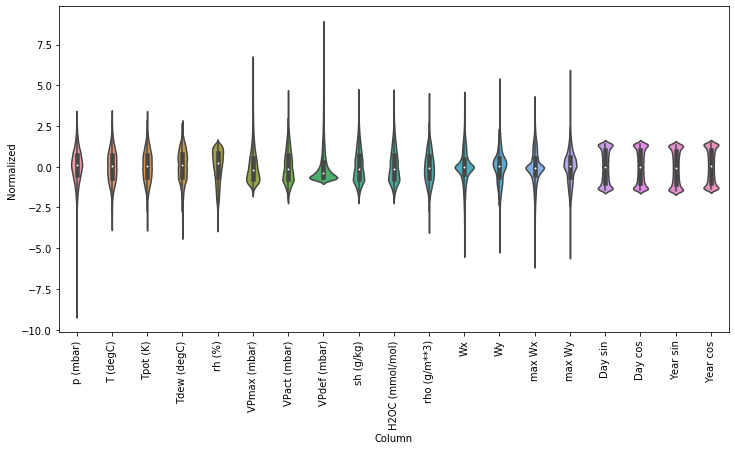

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# 입력 데이터 다루기
이 튜도리얼에서의 모델은 데이터의 연속된 샘플 창을 기반으로 일련의 예측을 수행한다.
입력 창의 주요 특성
- 입력 및 레이블 창의 너비
- 각 사이의 시간 오프셋
- 입력, 레이블 또는 둘 모두로 사용되는 특성

## 선형, DNN, CNN, RNN 모델 사용 목적
- 단일 출력 및 다중 출력 예측
- 단일 타임스텝 및 다중 타임스텝 예측

In [17]:
w1 = WindowGenerator(
    input_width=24,
    label_width=1,
    shift=24,
    train=train_df,
    val=val_df,
    test=test_df,
    label_columns=['T (degC)']
)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [18]:
w2 = WindowGenerator(
    input_width=6,
    label_width=1,
    shift=1,
    train=train_df,
    val=val_df,
    test=test_df,
    label_columns=['T (degC)']
)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [19]:
example_window = tf.stack([np.array(train_df[:w2.get_total_window_size()]),
                           np.array(train_df[100:100+w2.get_total_window_size()]),
                           np.array(train_df[200:200+w2.get_total_window_size()])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


In [20]:
w2._example = example_inputs, example_labels

Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']> and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']> and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-31 19:19:42.127608: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


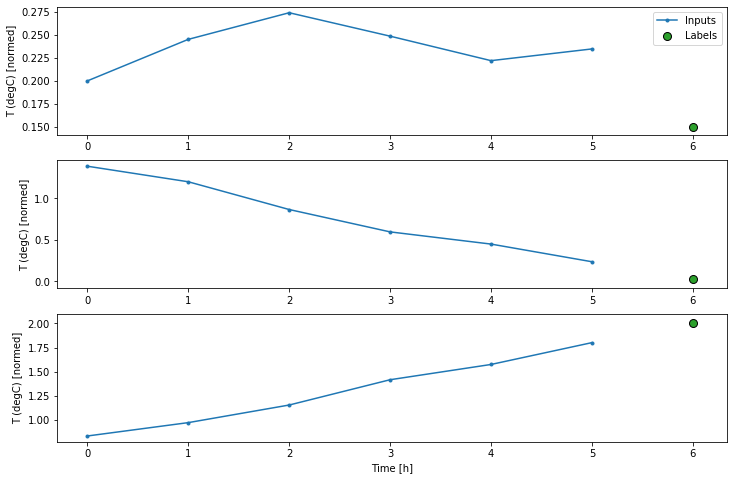

In [21]:
w2.plot()

In [22]:
for ex_inputs, ex_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {ex_inputs.shape}')
    print(f'Labels shape (batch, time, features): {ex_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [23]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, train=train_df, val=val_df, test=test_df,
    label_columns=['T (degC)']
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [24]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [25]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 900us/step - loss: 0.0131 - mean_absolute_error: 0.0794


In [26]:
wide_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1,
    train=train_df,
    val=val_df,
    test=test_df,
    label_columns=['T (degC)']
)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [27]:
wide_window._example = example_inputs, example_labels

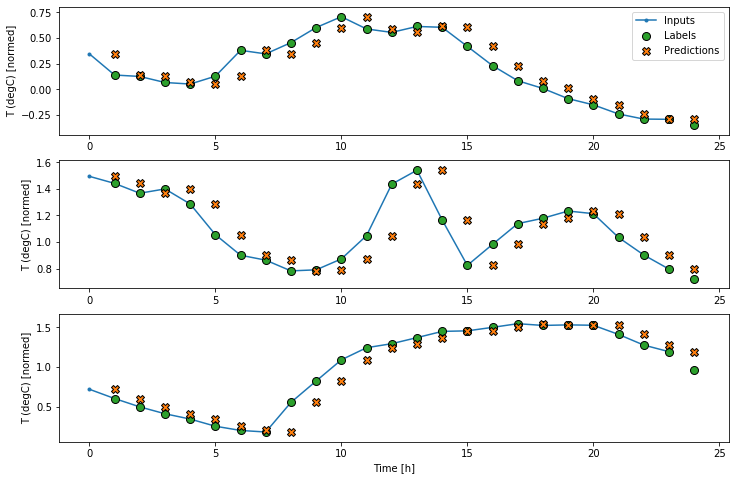

In [28]:
wide_window.plot(baseline)

In [29]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])

    return history

In [30]:
# LSTM model

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [31]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0055 - mean_absolute_error: 0.0508


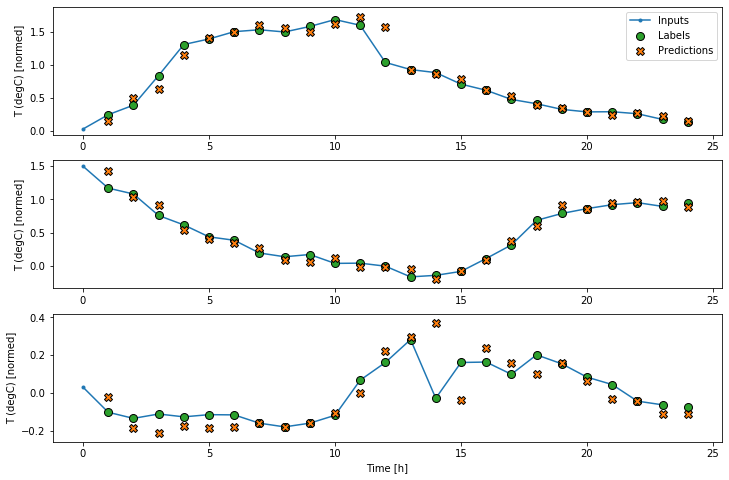

In [32]:
wide_window.plot(lstm_model)